# VGG Net16

VGGNet16 from Oxford VGG group consists of 16 weights layers and it is very appealing because of its very uniform architecture. VGGNet16 or VGG-16 uses 13 convolutional layers with ReLU activation function, divided into 5 blocks of Conv2D layers, each block end with 2x2 Max Pooling and stride of 2. Lastly, using 3 dense layer with Softmax activation.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import cv2
import glob
import shutil
from collections import Counter

from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import os
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('TensorFlow version', tf.__version__)

Using TensorFlow backend.


TensorFlow version 2.3.1


In [2]:
# Set up path

base_dir = os.path.join(os.getcwd(), 'dataset')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [3]:
folder_list = [x[0] for x in os.walk(base_dir)]
folder_list

['C:\\Users\\user\\Food_Classification\\dataset',
 'C:\\Users\\user\\Food_Classification\\dataset\\cheesecake',
 'C:\\Users\\user\\Food_Classification\\dataset\\chicken_curry',
 'C:\\Users\\user\\Food_Classification\\dataset\\chocolate_ice_cream',
 'C:\\Users\\user\\Food_Classification\\dataset\\french_toast',
 'C:\\Users\\user\\Food_Classification\\dataset\\fried_rice',
 'C:\\Users\\user\\Food_Classification\\dataset\\macarons',
 'C:\\Users\\user\\Food_Classification\\dataset\\nachos',
 'C:\\Users\\user\\Food_Classification\\dataset\\spaghetti_bolognese',
 'C:\\Users\\user\\Food_Classification\\dataset\\sushi',
 'C:\\Users\\user\\Food_Classification\\dataset\\test',
 'C:\\Users\\user\\Food_Classification\\dataset\\waffles']

In [4]:
folder_name = []
for i in folder_list:
    folder_name.append(os.path.basename(os.path.normpath(i)))
folder_name

['dataset',
 'cheesecake',
 'chicken_curry',
 'chocolate_ice_cream',
 'french_toast',
 'fried_rice',
 'macarons',
 'nachos',
 'spaghetti_bolognese',
 'sushi',
 'test',
 'waffles']

In [5]:
not_data_folder = ['dataset','test','train', 'val']
classes = list()

for word in folder_name:   #for each word in line.split()
    if word not in not_data_folder:    #if a word isn't in line.split            
        classes.append(word) 

classes

['cheesecake',
 'chicken_curry',
 'chocolate_ice_cream',
 'french_toast',
 'fried_rice',
 'macarons',
 'nachos',
 'spaghetti_bolognese',
 'sushi',
 'waffles']

In [6]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.copy(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.copy(v, os.path.join(base_dir, 'val', cl))

cheesecake: 50 Images
chicken_curry: 50 Images
chocolate_ice_cream: 50 Images
french_toast: 50 Images
fried_rice: 48 Images
macarons: 50 Images
nachos: 50 Images
spaghetti_bolognese: 49 Images
sushi: 48 Images
waffles: 50 Images


In [7]:
batch_size = 10
IMG_SHAPE = 224

image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size, directory=train_dir, shuffle=True,target_size=(IMG_SHAPE,IMG_SHAPE))

Found 395 images belonging to 10 classes.


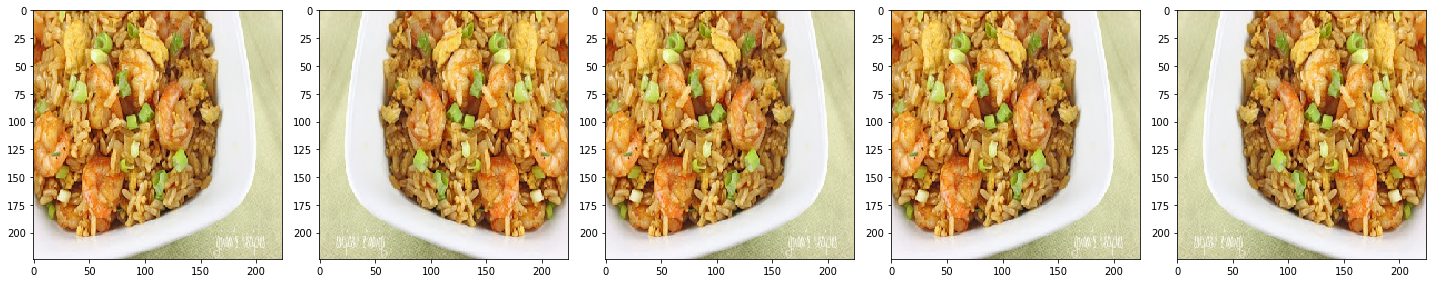

In [8]:
def plotImages(image_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip( image_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Found 395 images belonging to 10 classes.


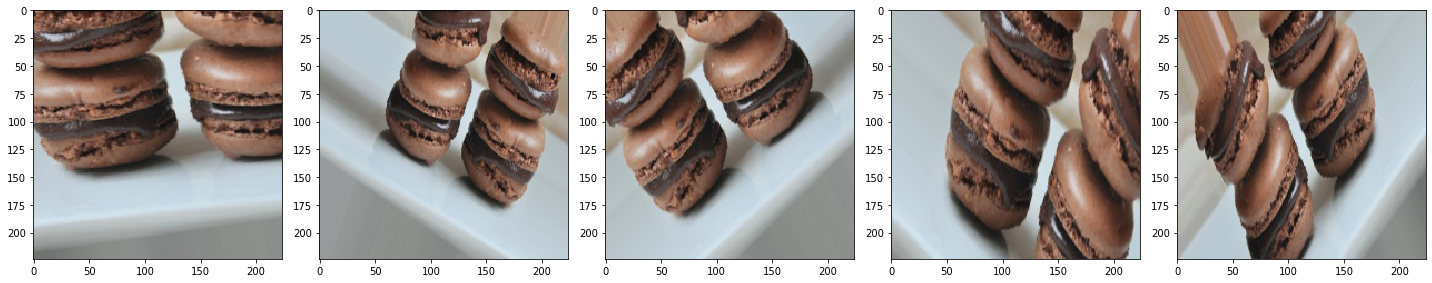

In [9]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [10]:
# validation data

image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 100 images belonging to 10 classes.


In [13]:
def Conv2D_block(input_layer, n_filters, layers_num):
    for i in range(layers_num):
        input_layer = Conv2D(n_filters, (3,3), padding='same', activation='relu')(input_layer)
    input_layer = MaxPool2D((2,2), strides=(2,2))(input_layer)
    return input_layer

In [15]:
layer = Input(shape =(IMG_SHAPE,IMG_SHAPE,3))

# VGG_Net-16 Block 1: Two layers with 64 filters
x = Conv2D_block(layer, 64, 2)

# VGG_Net-16 Block 2: Two layers with 128 filters
x = Conv2D_block(x, 128, 2)

# VGG_Net-16 Block 3: Two layers with 256 filters
x = Conv2D_block(x, 256, 3)

# VGG_Net-16 Block 4: Two layers with 512 filters
x = Conv2D_block(x, 512, 3)

# VGG_Net-16 Block 5: Two layers with 512 filters
x = Conv2D_block(x, 512, 3)


# Fully connected layers
x = Flatten()(conv_block)
x = Dense(units = 4096, activation ='relu')(x)
x = Dense(units = 4096, activation ='relu')(x)
output = Dense(units = 1000, activation ='softmax')(x)

model = Model (inputs=layer, outputs =output)
model.summary()

TypeError: object of type 'Dense' has no len()